**Проект:** анализ поведения пользователей приложения магазина продуктов питания

**Цель:** изучить воронку продаж, проанализировать результаты A/A/B-эксперимента по изменению шрифтов в приложении

## Откройте файл с данными и изучите общую информацию

In [ ]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

In [ ]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

logs.head()
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Подготовьте данные

### Замените названия столбцов на удобные

In [ ]:
logs.columns=['event_type', 'user_id', 'timestamp', 'group']
logs.loc[logs['group'] == 246,'group'] = 'A1'
logs.loc[logs['group'] == 247,'group'] = 'A2'
logs.loc[logs['group'] == 248,'group'] = 'B'
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_type  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   timestamp   244126 non-null  int64 
 3   group       244126 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.5+ MB


### Проверьте пропуски и типы данных. Откорректируйте.

In [ ]:
logs.head()

,event_type,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,A1
1,MainScreenAppear,7416695313311560658,1564053102,A1
2,PaymentScreenSuccessful,3518123091307005509,1564054127,B
3,CartScreenAppear,3518123091307005509,1564054127,B
4,PaymentScreenSuccessful,6217807653094995999,1564055322,B


In [ ]:
logs['timestamp'] = pd.to_datetime(logs['timestamp'], unit='s')
logs.head()

,event_type,user_id,timestamp,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B


In [ ]:
logs['event_type'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [ ]:
logs.isna().sum()

event_type    0
user_id       0
timestamp     0
group         0
dtype: int64

In [ ]:
logs.duplicated().sum()

413

In [ ]:
logs.loc[logs.duplicated()]

,event_type,user_id,timestamp,group
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,B
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,B
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,B
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,A2
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,B
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,2019-08-07 19:26:44,A2
242332,PaymentScreenSuccessful,4718002964983105693,2019-08-07 19:26:45,A2
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 19:27:29,A1
242362,CartScreenAppear,2382591782303281935,2019-08-07 19:27:29,A1


In [ ]:
logs = logs.drop_duplicates()

In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   timestamp   243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 9.3+ MB


In [ ]:
logs['date'] = pd.to_datetime(logs['timestamp']).dt.date
logs['date_time'] = pd.to_datetime(logs['timestamp'])
logs.head()

,event_type,user_id,timestamp,group,date,date_time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25,2019-07-25 11:48:42


**Вывод:** Переименовали столбцы по стилю, перевели столбец timestamp в формат datetime, создали отдельный столбец с датой. Проверили наличие явных дубликатов в таблице и неявных дубликатов в столбце event_type, проверили наличие пропусков в столбцах. Удалили 413 дубликатов (~0.17% от всех данных), что позволительно.

## Изучите и проверьте данные

### Сколько всего событий в логе?

In [ ]:
len(logs)

243713

### Сколько всего пользователей в логе?

In [ ]:
logs['user_id'].nunique()

7551

### Сколько в среднем событий приходится на пользователя?

In [ ]:
round(len(logs)/logs['user_id'].nunique())

32

### Данными за какой период вы располагаете?

In [ ]:
logs['timestamp'].min()

Timestamp('2019-07-25 04:43:36')

In [ ]:
logs['timestamp'].max()

Timestamp('2019-08-07 21:15:17')

**Комментарий:** располагаем данными за 14 дней, построим гистограмму на 14 корзин, чтобы посмотреть распределение событий по дате и времени.

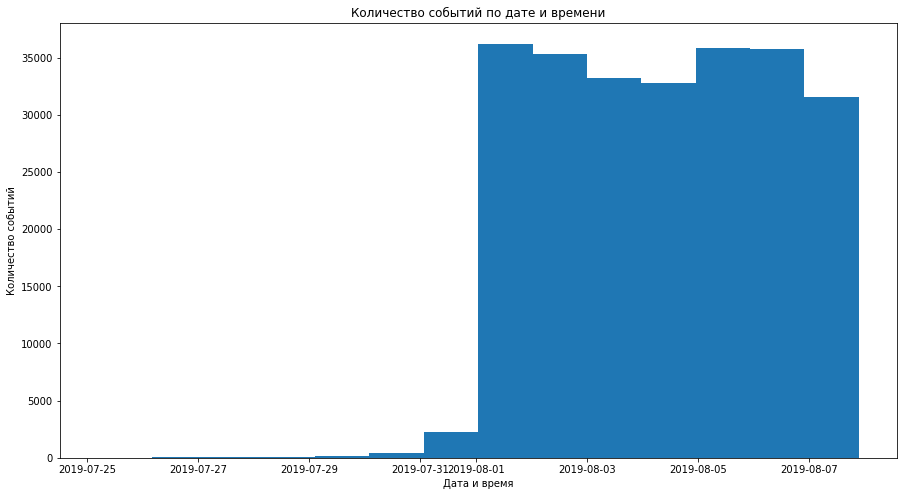

In [ ]:
plt.figure(figsize=(15,8))
plt.hist(logs['timestamp'], bins=14)
plt.xlabel('Дата и время')
plt.ylabel('Количество событий')
plt.title('Количество событий по дате и времени');

**Комментарий:** на гистограмме видим, что событий с 7 июля до 31 июля включительно количество событий аномально низкое, можно предположить, что эти события - подгружаемые из прошлого логи, поэтому реальные события, которыми мы располагаем, происходили с 1 по 7 августа, их и оставим.

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [ ]:
logs.loc[logs['timestamp'] < '2019-08-01']

,event_type,user_id,timestamp,group,date,date_time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25,2019-07-25 11:48:42
...,...,...,...,...,...,...
2823,OffersScreenAppear,2413191300976302222,2019-07-31 23:54:55,A2,2019-07-31,2019-07-31 23:54:55
2824,MainScreenAppear,5505110279185484837,2019-07-31 23:57:30,A2,2019-07-31,2019-07-31 23:57:30
2825,MainScreenAppear,5505110279185484837,2019-07-31 23:57:42,A2,2019-07-31,2019-07-31 23:57:42
2826,MainScreenAppear,5505110279185484837,2019-07-31 23:57:52,A2,2019-07-31,2019-07-31 23:57:52


In [ ]:
round((2826 * 100/len(logs)), 2)

1.16

**Комментарий:** удаляем 2826 наблюдений, 1,16% от всех наблюдений

In [ ]:
logs = logs.loc[logs['timestamp'] > '2019-07-31']

In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242917 entries, 797 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_type  242917 non-null  object        
 1   user_id     242917 non-null  int64         
 2   timestamp   242917 non-null  datetime64[ns]
 3   group       242917 non-null  object        
 4   date        242917 non-null  object        
 5   date_time   242917 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 13.0+ MB


In [ ]:
logs['user_id'].nunique()

7542

In [ ]:
round((logs['user_id'].nunique() * 100/7551), 2)

99.88

**Комментарий:** осталось 99,88% пользователей, удалили всего 9 пользователей.

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [ ]:
logs.groupby('group').agg({'user_id' : 'nunique'})

,user_id
group,
A1,2485
A2,2517
B,2540


**Комментарий:** в каждой группе примерно по 2500 пользователей.

In [ ]:
duplicates = logs[['user_id', 'group']].groupby('user_id').agg({'group' : 'nunique'}).query('group == 2')
duplicates

,group
user_id,


**Комментарий:** в группах нет пользователей, попавших в две и более группы одновременно.

## Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

In [ ]:
logs['event_type'].unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'Tutorial',
       'PaymentScreenSuccessful', 'CartScreenAppear'], dtype=object)

In [ ]:
logs['event_type'].value_counts()

MainScreenAppear           118578
OffersScreenAppear          46707
CartScreenAppear            42560
PaymentScreenSuccessful     34058
Tutorial                     1014
Name: event_type, dtype: int64

**Комментарий:** самое частое событие - переход на главный экран, далее - экран с предложениями, корзина, успешная оплата и самое крайнее - обучение.

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [ ]:
logs.groupby('event_type').agg({'user_id' : 'count'})

**Комментарий:** пользователи распределены также, как частота событий.

In [ ]:
users_sorted = logs.groupby('event_type').agg({'user_id' : 'nunique'}).reset_index().sort_values(by='user_id', ascending=False)
users_sorted['percentage'] = round((users_sorted['user_id'] / logs['user_id'].nunique()), 2)
users_sorted

,event_type,user_id,percentage
1,MainScreenAppear,7429,0.99
2,OffersScreenAppear,4606,0.61
0,CartScreenAppear,3742,0.50
3,PaymentScreenSuccessful,3542,0.47
4,Tutorial,845,0.11


**Комментарий:** 99% пользователей хотя бы раз попали на главный экран, 60% попадали на экран с предложениями, половина пользователей были на странице корзины, 47% купили что-то, 11% прошли обучение.

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?

**Комментарий:** события выстраиваются в цепочку: MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful, событие Tutorial не попадают в последовательную цепочку, т.к. не все пользователи открывают и проходят обучение.

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки.

In [ ]:
users_sorted

,event_type,user_id,percentage
1,MainScreenAppear,7429,0.99
2,OffersScreenAppear,4606,0.61
0,CartScreenAppear,3742,0.50
3,PaymentScreenSuccessful,3542,0.47
4,Tutorial,845,0.11


In [ ]:
users_sorted = users_sorted.drop(4)

In [ ]:
round((users_sorted['user_id'] / users_sorted['user_id'].shift()), 2)

1     NaN
2    0.62
0    0.81
3    0.95
Name: user_id, dtype: float64

**Комментарий:** 62% пользователей из вошедших на главный экран приложения переходит на страницу с предложениями, из них 81% добавляют товар в корзину и из них 95% совершает покупку.

### На каком шаге теряете больше всего пользователей?

**Комментарий:** самое большое количество пользователей теряется на этапе перехода на страницу с товарами, из всего количества пользователей открывающих главную страницу приложения только 62% переходит на страницу с товаром.

### Какая доля пользователей доходит от первого события до оплаты?

In [ ]:
round((users_sorted['user_id'].loc[users_sorted.index[3]] * 100 /users_sorted['user_id'].loc[users_sorted.index[0]]), 2)

47.68

**Комментарий:** от количества посетителей, побывавших на главной странице приложения, покупку совершили 47,68% пользователей.

## Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

In [ ]:
logs.groupby('group').agg({'user_id' : 'nunique'})

,user_id
group,
A1,2485
A2,2517
B,2540


**Комментарий:** в каждой группе приблизительно по 2500 пользователей.

### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247

In [ ]:
logs_aa = logs.pivot_table(index='event_type', columns='group', values='user_id',
                                                 aggfunc='nunique').reset_index()

logs_aa['C'] = logs_aa['A1'] + logs_aa['A2']
logs_aa

group,event_type,A1,A2,B,C
0,CartScreenAppear,1267,1239,1236,2506
1,MainScreenAppear,2452,2479,2498,4931
2,OffersScreenAppear,1544,1526,1536,3070
3,PaymentScreenSuccessful,1200,1159,1183,2359
4,Tutorial,278,285,282,563


In [ ]:
logs_total = logs.groupby('group').agg({'user_id' : 'nunique'})
logs_total.columns = ['count']
logs_total.loc['C'] = [logs_total.loc['A1', 'count'] + logs_total.loc['A2', 'count']]
logs_total

,count
group,
A1,2485
A2,2517
B,2540
C,5002


**Комментарий:** сформулируем гипотезы для проверки равенства долей в двух контрольных группах.

**Нулевая:** доли в двух контрольных группах равны.
**Альтернативная:** доли в двух контрольных группах не равны.

In [ ]:
def z_test (group_1, group_2, event, alpha):

    trials = np.array([logs_total.loc[group_1],
                      logs_total.loc[group_2]])
    successes = np.array([logs_aa.loc[logs_aa['event_type'] == event][group_1],
                          logs_aa.loc[logs_aa['event_type'] == event][group_2]])


    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2

    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value, event)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [ ]:
for i in range(len(logs_aa)):
    z_test('A1', 'A2', logs_aa.loc[i, 'event_type'], 0.0026)

p-значение:  [0.21306132] CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.58687768] MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.2743506] OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11210845] PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.87916084] Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Комментарий:** тест показал, что по всем событиям статистическая значимость более 1%, поэтому нет оснований отвергнуть гипотезу о равенстве долей в группах. Значит группы А1 и А2 имеют одинаковые показатели, тест проведён правильно.

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

In [ ]:
users_sorted

,event_type,user_id,percentage
1,MainScreenAppear,7429,0.99
2,OffersScreenAppear,4606,0.61
0,CartScreenAppear,3742,0.50
3,PaymentScreenSuccessful,3542,0.47


**Комментарий:** самое популярное событие - MainScreenAppear.

In [ ]:
popular_event = logs.query('event_type == "MainScreenAppear"').groupby('group').agg({'user_id' : 'nunique'}).join(logs_total)
popular_event.columns = ['count', 'total']
popular_event['percentage'] = round(popular_event['count'] * 100 / popular_event['total'], 2)
popular_event

,count,total,percentage
group,,,
A1,2452,2485,98.67
A2,2479,2517,98.49
B,2498,2540,98.35


**Комментарий:** доля пользователей, совершивших вход на главный экран 98% во всех трех группах.

**Комментарий** снова считаем статистическую значимость равенства долей пользователей, попавших на то или иное событие в двух контрольных группах.

**Комментарий:** сформулируем гипотезы для проверки равенства долей в двух контрольных группах.

**Нулевая:** доли в двух контрольных группах равны.
**Альтернативная:** доли в двух контрольных группах не равны.

In [ ]:
def z_test (group_1, group_2, event, alpha):

    trials = np.array([logs_total.loc[group_1],
                      logs_total.loc[group_2]])
    successes = np.array([logs_aa.loc[logs_aa['event_type'] == event][group_1],
                          logs_aa.loc[logs_aa['event_type'] == event][group_2]])


    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2

    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value, event)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

In [ ]:
for i in range(len(logs_aa)):
    z_test('A1', 'A2', logs_aa.loc[i, 'event_type'], 0.0026)

p-значение:  [0.21306132] CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.58687768] MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.2743506] OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.11210845] PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.87916084] Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Комментарий:** тест показал, что p-value более 1% и даже более 5%, поэтому нет оснований отвергать гипотезу о равентстве долей в контрольных группах. Распределение между группами можно считать корректным.

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

**Комментарий:** сформулируем гипотезы для проверки равенства долей в группах A1 и B.

**Нулевая:** доли в двух группах равны.
**Альтернативная:** доли в двух группах не равны.

In [ ]:
for i in range(len(logs_aa)):
    z_test('A1', 'B', logs_aa.loc[i, 'event_type'], 0.0026)

p-значение:  [0.09941722] CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.34128639] MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.2269968] OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.22352232] PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.92394674] Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Комментарий:** между группами А1 и В по результатам теста нет значимых различий, p-value более 5% (минимум 9%, максимум 92%), нет оснований отвергать нулевую гипотезу.

**Комментарий:** сформулируем гипотезы для проверки равенства долей в группах A2 и B.

**Нулевая:** доли в двух группах равны.
**Альтернативная:** доли в двух группах не равны.

In [ ]:
for i in range(len(logs_aa)):
    z_test('A2', 'B', logs_aa.loc[i, 'event_type'], 0.0026)

p-значение:  [0.68837995] CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.68195838] MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.91005174] OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.70658947] PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.80363652] Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Комментарий:** между группами А2 и В по результатам теста нет значимых различий, p-value более 5% (минимум 68%, максимум 91%), нет оснований отвергать нулевую гипотезу.

**Комментарий:** сформулируем гипотезы для проверки равенства долей в экспериментальной группе B и двумя контрольными группами вместе - C (A1+A2).

**Нулевая:** доли в двух группах равны.
**Альтернативная:** доли в двух группах не равны.

In [ ]:
for i in range(len(logs_aa)):
    z_test('B', 'C', logs_aa.loc[i, 'event_type'], 0.0026)

p-значение:  [0.23764471] CartScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.42897263] MainScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.44718094] OffersScreenAppear
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.62966831] PaymentScreenSuccessful
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  [0.84205237] Tutorial
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Комментарий:** между группами B и C(A1+A2) по результатам теста нет значимых различий, p-value более 5% (минимум 23%, максимум 84%), нет оснований отвергать нулевую гипотезу.

**Вывод:** по результатам сравнения всех трех групп, проведения статистических тестов выяснили, что между всеми группами нет значительных различий, статистическая значимость более 5%, в среднем, более чем 20%.

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить?

При проведении тестов выбрали статистическую значимость в 5%. Всего было проведено 20 проверок статистических гипотез. Однако, при многочисленном проведении сравнений есть вероятность ложноположительного результата, поэтому необходимо скорректировать уровень статистической значимости. Рассчитаем её с помощью поправки Шидака и проделаем тесты с помощью скорректированного значения.

In [ ]:
alpha_shidak = 1 - (1 - 0.05)**(1/20)
alpha_shidak
round(alpha_shidak, 4)

0.0026

## Вывод

По результатам исследования воронки событий и анализа результатов A/B теста, выяснили, что нет значительной разницы между долями пользователей, совершаюших то или иное событие во всех трех группах. Вероятность равенства долей между группами составила в среднем более 20%, достигая 90% и более.

Был проведён A/A тест для проверки корректности проведённого A/B теста. Результаты подтвердились.

По результатам теста, говорящих об отстутствии значительных различий по событиям в контрольных группах и экспериментальной группе, делаем вывод, что новые шрифты не влияют на поведение покупателей, поэтому не имеет смысла их изменять для увеличения конверсии.